In [1]:
import pandas as pd
import recordlinkage
pd.options.display.max_columns = None

### Load Data fiels

In [2]:
ama = pd.read_stata('ama13.dta')

In [3]:
meetings = pd.read_excel('speakerData.xlsx')
meetings = meetings.drop("meetingID", axis='columns')
meetings['nonus'] = ~(meetings.us==1)

In [4]:
ama.loc[ama.npi=="1528185246"]

,ResearchID,npi,MailFirstName,MailMiddleName,MailLastName,AddressType,MailAddress1,MailZipCode,MailZip5,Undeliverable,FIPSCounty,FIPSCity,FIPSState,CensusRegion,CensusDivision,CensusGroup,CensusTract,CensusSuffix,CensusBlockGroup,CensusEnumerationGroup,cmsa,PMSA_MSA,smsa,msa,DOFlag,BirthDate,BirthCity,BirthState,BirthCountry,Sex,DeadFlag,LicPrefState,LicPrefYear,LicGrpState,LicGrpYear,LicHospState,LicHospYear,LicAltOffState,LicAltOffYear,PrimaryTOP,PresentEmployment,PrimarySpecialty,SecondarySpecialty,tops,HospitalID,HospitalHours,PRAFlag,PRAExpiration,GroupID1,GroupID2,MedTrainFlag,MedTrainFrom,MedTrainTo,MedTrainYearInProgram,MedTrainPostGradYear,MedTrainSpec1,MedTrainSpec2,MedTrainingInstitutionCode,MedSchoolID,MedSchoolYOG,ContactFlag,NumberOfOffices,OfficeState,OfficeZipCode,USTrained,ResidencyTrainingState,MedicalSchoolState,OmitFlag,yob,yot
559538,3740050891,1528185246,James,Francis,Burke,2,NA,48103-3147,48103,0,161,NA,26,2.0,3.0,6,4007,00,0,NA,35,0440,NA,A,0,5844.0,CLEVELAND,OH,US1,M,0,MI,2009,NA,NA,NA,NA,MI,2009,020,110,VN,US,PO,NA,000,0,NaN,NA,NA,0,NA,18443.0,0,0,NA,NA,250256,01643,2005,1,0,MI,48109-5002,0,MI,IL,NA,1976,2010.0


### Step 2: filter ama list to neurology and related specialities.

Neurology specialities from AMA masterfile

<li>MN	Internal Medicine - Neurology</li>
<li>N	Neurology</li>
<li>NDN	Neurodevelopmental Disabilities</li>
<li>NDP	Neurodevelopmental Disabilities</li>
<li>NMN	Neuromuscliar Medicine</li>
<li>NNM	Neurology / Nuclear Medicine</li>
<li>NS	Neurological Surgery</li>
<li>NSP	Pediatric Neurological Surgery</li>
<li>NUP	Neuropsychiatry</li>
<li>PMN	Pain Medicine (Neurology)</li>
<li>PYN	Psychiatry - Neurology</li>
<li>SMN	Sleep Medicine (Psych & Neurology)</li>
<li>SMA/SME	Sleep Medicine )</li>
<li>HPN Hospice and palliative neurology</li>

<li>VN	Vascliar Neurology</li>
<li>CHN Child neurology</li>
<li> EPL Epilepsy</li>
<li>NO Neuro-otology</li>
<li>Neurology/diagnostic radiology</li>

In [5]:
ama['MailFirstName'] = ama['MailFirstName'].str.lower()
ama['MailLastName'] = ama['MailLastName'].str.lower()
ama['MailMiddleName'] = ama['MailMiddleName'].str.lower()
meetings['firstName'] = meetings['firstName'].str.lower()
meetings['lastName'] = meetings['lastName'].str.lower()
ama['middleInitial'] = ama['MailMiddleName'].str[:1]
# new data frame with split value columns 
splitName = meetings["firstName"].str.split(" ", n = 1, expand = True) 
# making seperate first name column from new data frame 
meetings["firstName"]= splitName[0] 
meetings["middleInitial"]= splitName[1].str.strip(".")
meetings["middleInitial"]= meetings['middleInitial'].str[:1]
ama['female'] = ama['Sex'] == 'F'
ama['female'] = ama['female'].astype(int)
# the Year of graduation field looks awful...
ama['MedSchoolYOG'] = ama['MedSchoolYOG'].astype(int)
ama['YOGEst'] = ama.yot - 4

In [6]:
neuroSpecialties = ['MN', 'N', 'NDN', 'NMN', 'NNM', 'NS', 'NSP', 'NUP', 'PMN', 'PYN', 'SMN', 'VN', 'CHN', 'EPL', 'SMA', 'SME', 'HPN', 'NO', 'NRN']
primaryNeuro = ama.loc[ama['PrimarySpecialty'].isin(neuroSpecialties)]
secondaryNeuro = ama.loc[ama['SecondarySpecialty'].isin(neuroSpecialties)]
allNeuro = pd.concat([primaryNeuro,secondaryNeuro]).drop_duplicates().reset_index(drop=True)

In [7]:
meetings['totalNonMissing'] = meetings[['lastName', 'firstName', 'middleInitial', 'female', 'medGradYear']].notnull().sum(axis=1)
meetings['weightedNonMissing'] = meetings['middleInitial'].notnull() * 0.25 + 3.05

### Match meetings to the file of neurologists

In [8]:
usmeetings = meetings.loc[meetings.us==1] 
meetingAMAMatchIndex = recordlinkage.index.SortedNeighbourhood(left_on='lastName', right_on='MailLastName', window=11)
personMatch = meetingAMAMatchIndex.index(usmeetings, allNeuro)
personMatch.names = ['meetingID', 'amaID']
dfTest = pd.DataFrame(index=personMatch)
allNeuro.index.name = 'amaID'

In [9]:
personComp = recordlinkage.Compare(n_jobs=12)
personComp.string('lastName', 'MailLastName', method='jarowinkler')
personComp.string('firstName', 'MailFirstName', method='jarowinkler')
personComp.string('middleInitial', 'middleInitial', method='jarowinkler')
personComp.exact('female', 'female')
personComp.numeric('medGradYear', 'YOGEst', method='linear', offset=2, scale=2)

personCompared = personComp.compute(personMatch, usmeetings, allNeuro)
personCompared = personCompared.rename({0:"lastNameWeight", 1:"firstNameWeight", 2:"middleInitialWeight", 3:"femaleWeight", 4:"medGradWeight"}, axis='columns')
personCompared['totalWeight'] = personCompared.lastNameWeight + personCompared.firstNameWeight + personCompared.middleInitialWeight + personCompared.femaleWeight + personCompared.medGradWeight
personCompared['arbWeight'] = personCompared.lastNameWeight + personCompared.firstNameWeight * 0.8 + personCompared.middleInitialWeight * 0.25 + personCompared.femaleWeight + personCompared.medGradWeight * 0.25

In [10]:
joined = personCompared.join(usmeetings, on='meetingID', how='left').join(allNeuro, on='amaID', how='left', lsuffix='left', rsuffix='right')

In [11]:
joined['percentWeight'] = joined.totalWeight / joined.totalNonMissing
joined['arbPercentWeight'] = joined.arbWeight / joined.weightedNonMissing
joined.sort_values(['meetingID', 'percentWeight', 'arbPercentWeight'], ascending=False, inplace=True)
simpleJoin = joined[[ 'percentWeight', 'arbPercentWeight', 'lastName', 'firstName', 'femaleleft', 'middleInitialleft', 'medGradYear', 'MailFirstName', 'MailLastName', 'middleInitialright', 'femaleright', 'YOGEst']]


### Multiple manual comparisons bewteen matches using the (commented out to make notebook more succinct) code below, generating the file matchData.xlsx

In [12]:
#simpleJoin.loc[(1490,)]

In [13]:
#joined.loc[(1490,)]

In [14]:
joined['rankWithinMeeting'] = joined.groupby(["meetingID"]).cumcount()
joined['nextPercentWeight'] = joined.groupby('meetingID')['percentWeight'].shift(-1) 
joined['nextPercentArb'] = joined.groupby('meetingID')['arbPercentWeight'].shift(-1) 
joined['weightDelta'] = joined.percentWeight - joined.nextPercentWeight 
joined['arbDelta'] = joined.arbPercentWeight - joined.nextPercentArb
joined['exactNameMatch'] = (joined.lastNameWeight==1) & (joined.firstNameWeight==1)

In [15]:
exactMatchesForMeeting = joined.groupby("meetingID").exactNameMatch.sum()
exactMatchesForMeeting.rename("exactMatchesForMeeting", inplace=True)
joined = joined.join(other=exactMatchesForMeeting, on='meetingID', how='left')

In [16]:
bestMatchForMeeting = joined.loc[joined['rankWithinMeeting'] == 0]

In [17]:
#matchCharacteristics[['arb','match', 'weight', 'weightDelta', 'arbDelta']].groupby(['match']).describe()

1. The highest unmathced weight is 0.89 and the highest unmathced arb is 0.91...so, we can use those as simple threshods for "if you're above this...call it a match"

2. Matches also have higher "gaps" between themselves and the next best match. so, we can probably also build a criterion on a large "gap" and a slightly lowe weight. Maybe go down to the lowest matched weight (0.73) and arb (0.83) with a 25th percentile matched delta (arb 0.27, weight 0.25) which is larger than the 75th percentile for non matches.

### make matches. in neuro


In [18]:
nearExactWeightMatches = bestMatchForMeeting.loc[bestMatchForMeeting.percentWeight > 0.90]
nearExactArbWeightMatches = bestMatchForMeeting.loc[bestMatchForMeeting.arbPercentWeight > 0.92]

moderateWeightMatchWithLargeGap = bestMatchForMeeting.loc[(bestMatchForMeeting.percentWeight <= 0.90) & (bestMatchForMeeting.percentWeight > 0.73) & (bestMatchForMeeting.weightDelta > 0.25)]
moderateArbMatchWithLargeGap = bestMatchForMeeting.loc[(bestMatchForMeeting.arbPercentWeight <= 0.92) & (bestMatchForMeeting.arbPercentWeight > 0.83) & (bestMatchForMeeting.arbDelta > 0.27)]

exactAndOnlyNameMatch = bestMatchForMeeting.loc[(bestMatchForMeeting.exactNameMatch) & (bestMatchForMeeting.exactMatchesForMeeting==1)]

neuroMatches = pd.concat([nearExactArbWeightMatches, nearExactWeightMatches, moderateArbMatchWithLargeGap, moderateWeightMatchWithLargeGap, exactAndOnlyNameMatch]).drop_duplicates()

60% seem are matched using pretty solid near exact matches. will 

In [19]:
len(neuroMatches)/len(usmeetings)

0.6505332239540607

### now try to match the unmatched to the non-neuro ama file

In [20]:
unmatchedMeetings = usmeetings.loc[~usmeetings.index.isin(neuroMatches.index.get_level_values(0))]
nonNeuro = ama.loc[ama.ResearchID.isin(set(ama.ResearchID) - set(allNeuro.ResearchID))]

In [21]:
nonNeuroMeetingAMAMatch = recordlinkage.index.SortedNeighbourhood(left_on='lastName', right_on='MailLastName', window=11)
nonNeuroPersonMatch = nonNeuroMeetingAMAMatch.index(unmatchedMeetings, nonNeuro)
nonNeuroPersonMatch.names = ['meetingID', 'amaID']

In [22]:
nonNeuroComp = recordlinkage.Compare(n_jobs=12)
nonNeuroComp.string('lastName', 'MailLastName', method='jarowinkler')
nonNeuroComp.string('firstName', 'MailFirstName', method='jarowinkler')
nonNeuroComp.string('middleInitial', 'middleInitial', method='jarowinkler')
nonNeuroComp.exact('female', 'female')
nonNeuroComp.numeric('medGradYear', 'YOGEst', method='linear', offset=2, scale=2)

nonNeuroCompared = nonNeuroComp.compute(nonNeuroPersonMatch, unmatchedMeetings, nonNeuro)

In [23]:
nonNeuroCompared = nonNeuroCompared.rename({0:"lastNameWeight", 1:"firstNameWeight", 2:"middleInitialWeight", 3:"femaleWeight", 4:"medGradWeight"}, axis='columns')
nonNeuroCompared['totalWeight'] = nonNeuroCompared.lastNameWeight + nonNeuroCompared.firstNameWeight + nonNeuroCompared.middleInitialWeight + nonNeuroCompared.femaleWeight + nonNeuroCompared.medGradWeight
nonNeuroCompared['arbWeight'] = nonNeuroCompared.lastNameWeight + nonNeuroCompared.firstNameWeight * 0.8 + nonNeuroCompared.middleInitialWeight * 0.25 + nonNeuroCompared.femaleWeight + nonNeuroCompared.medGradWeight * 0.25

In [24]:
nonNeuroJoined = nonNeuroCompared.join(unmatchedMeetings, on='meetingID', how='left').join(nonNeuro, on='amaID', how='left', lsuffix='left', rsuffix='right')

nonNeuroJoined['percentWeight'] = nonNeuroJoined.totalWeight / nonNeuroJoined.totalNonMissing
nonNeuroJoined['arbPercentWeight'] = nonNeuroJoined.arbWeight / nonNeuroJoined.weightedNonMissing

nonNeuroJoined.sort_values(['meetingID', 'percentWeight', 'arbPercentWeight'], ascending=False, inplace=True)
nonNeuroSimpleJoin = nonNeuroJoined[[ 'percentWeight', 'arbPercentWeight', 'lastName', 'firstName', 'femaleleft', 'middleInitialleft', 'medGradYear', 'MailFirstName', 'MailLastName', 'middleInitialright', 'femaleright', 'YOGEst']]

In [25]:
nonNeuroSimpleJoin.index.get_level_values(0).unique()

Int64Index([1492, 1490, 1489, 1488, 1487, 1486, 1484, 1480, 1476, 1474,
            ...
              61,   48,   47,   45,   44,   36,   20,   19,   16,   10],
           dtype='int64', name='meetingID', length=426)

In [26]:
#nonNeuroSimpleJoin.loc[(44,)]

In [27]:
nonNeuroJoined.sort_values(['meetingID', 'arbPercentWeight', 'percentWeight'], ascending=False, inplace=True)
nonNeuroJoined['rankWithinMeeting'] = nonNeuroJoined.groupby(["meetingID"]).cumcount()
nonNeuroJoined['nextPercentWeight'] = nonNeuroJoined.groupby('meetingID')['percentWeight'].shift(-1) 
nonNeuroJoined['nextPercentArb'] = nonNeuroJoined.groupby('meetingID')['arbPercentWeight'].shift(-1) 
nonNeuroJoined['weightDelta'] = nonNeuroJoined.percentWeight - nonNeuroJoined.nextPercentWeight 
nonNeuroJoined['arbDelta'] = nonNeuroJoined.arbPercentWeight - nonNeuroJoined.nextPercentArb

bestNonNeuroMatchForMeeting = nonNeuroJoined.loc[nonNeuroJoined['rankWithinMeeting'] == 0]

In [28]:
nonNeuroNearExactWeightMatches = bestNonNeuroMatchForMeeting.loc[(bestNonNeuroMatchForMeeting.percentWeight > 0.90) & (bestNonNeuroMatchForMeeting.weightDelta > 0.01)]
nonNeuroNearExactArbWeightMatches = bestNonNeuroMatchForMeeting.loc[(bestNonNeuroMatchForMeeting.arbPercentWeight > 0.92) & (bestNonNeuroMatchForMeeting.arbDelta > 0.01)]

nonNeuroModerateWeightMatchWithLargeGap = bestNonNeuroMatchForMeeting.loc[(bestNonNeuroMatchForMeeting.percentWeight <= 0.90) & (bestNonNeuroMatchForMeeting.percentWeight > 0.73) & (bestNonNeuroMatchForMeeting.weightDelta > 0.25)]
nonNeuroModerateArbMatchWithLargeGap = bestNonNeuroMatchForMeeting.loc[(bestNonNeuroMatchForMeeting.arbPercentWeight <= 0.92) & (bestNonNeuroMatchForMeeting.arbPercentWeight > 0.83) & (bestNonNeuroMatchForMeeting.arbDelta > 0.27)]

nonNeuroMatches = pd.concat([nonNeuroNearExactWeightMatches, nonNeuroNearExactArbWeightMatches, nonNeuroModerateWeightMatchWithLargeGap, nonNeuroModerateArbMatchWithLargeGap]).drop_duplicates()

In [29]:
len(nonNeuroMatches)/len(usmeetings)

0.17883511074651354

In [30]:
unmatchedMeetings2 = unmatchedMeetings.loc[~unmatchedMeetings.index.isin(nonNeuroMatches.index.get_level_values(0))]
len(unmatchedMeetings2)/len(usmeetings)

0.17063166529942575

In [37]:
#unmatchedMeetings2.tail(50)

### factors we can match on directly: 
<ol>
    <li>first name</li>
    <li>last name</li>
    <li>middle initial</li>
    <li> sex </li>
    <li>med school year of graduation</li>
</ol>

### factors that we can match/filter on somewhat: 
<ol>
    <li> residency training institution vs. current institution (assuming there is a lot of overlap)</li>
    <li> curent hospital name...althjough huge limitation that its missing for 85% of the samle</li>
    <li> current mailing zip code (ama masterfile) vs. hospital zip code (will n eed to be matched into speaker file</li>
    <li>US trained in both files</li>
    <li> maybe there is a way to link the academic filter? although probably not that useful given its prevalence</li>
</ol>

    

In [31]:
meetings['neuroMatch'] = meetings.index.isin(neuroMatches.index.get_level_values(0))
meetings['nonNeuroMatch'] =meetings.index.isin(nonNeuroMatches.index.get_level_values(0))
meetings['unmatched'] = meetings.index.isin(unmatchedMeetings2.index)
meetings[['neuroMatch','nonNeuroMatch', 'unmatched', 'nonus']] = meetings[['neuroMatch','nonNeuroMatch', 'unmatched', 'nonus']].astype(int)
meetings['matchCategory'] = meetings[['neuroMatch','nonNeuroMatch', 'unmatched', 'nonus']].idxmax(axis=1)

### How was the overall match?

In [32]:
meetings.matchCategory.value_counts()

neuroMatch       793
nonus            275
nonNeuroMatch    218
unmatched        208
Name: matchCategory, dtype: int64

### Compare the speakers data across the categories of matches...

1. We have a small problem with the unmatched group where women are more common
2. Women speakers are less common amongst non-US speakers...
3. Non-US speakers have higher pub counts
4. non-neuro meetings have more recnet grads with fewer pubs

In [33]:
import numpy as np
meetings.replace(-1, np.nan, inplace=True)
meetings.pivot_table(index=meetings.matchCategory, dropna=True, aggfunc=( 'mean', 'std')).transpose()

matchCategory             neuroMatch  nonNeuroMatch        nonus    unmatched
academic           mean     0.952081       0.963303     0.989091     0.932692
                   std      0.213730       0.188450     0.104065     0.251159
female             mean     0.288777       0.307339     0.185654     0.346341
                   std      0.453480       0.462453     0.389650     0.476968
honorificSpeaker   mean     0.000000       0.000000     0.000000     0.000000
                   std      0.000000       0.000000     0.000000     0.000000
leadership         mean     0.359395       0.151376     0.047273     0.105769
                   std      0.702244       0.517013     0.272763     0.391165
medGradYear        mean  1992.368153    1995.041667  1992.920455  1993.097143
                   std     10.991799      10.611233     9.135282    11.357652
neuroMatch         mean     1.000000       0.000000     0.000000     0.000000
                   std      0.000000       0.000000     0.000000     0.000000
nonNeuroMatch      mean     0.000000       1.000000     0.000000     0.000000
                   std      0.000000       0.000000     0.000000     0.000000
nonus              mean     0.000000       0.000000     1.000000     0.000000
                   std      0.000000       0.000000     0.000000     0.000000
pubsScopus         mean   117.897078     101.934579   172.514894   105.930000
                   std    133.621463     111.815263   161.102514   145.516081
scopusHIndex       mean    28.673885      25.897196    32.773504    24.974747
                   std     26.572641      22.167283    23.104446    25.711092
speaker            mean     0.701135       0.353211     0.105455     0.288462
                   std      1.132714       0.730516     0.467724     1.064791
totalNonMissing    mean     4.504414       4.243119     4.192727     4.250000
                   std      0.500296       0.429954     0.395160     0.434057
unmatched          mean     0.000000       0.000000     0.000000     1.000000
                   std      0.000000       0.000000     0.000000     0.000000
us                 mean     1.000000       1.000000     0.000000     1.000000
                   std      0.000000       0.000000     0.000000     0.000000
weightedNonMissing mean     3.176103       3.110780     3.098182     3.112500
                   std      0.125074       0.107488     0.098790     0.108514

### Explore the distribution of women in the neurology sample of the AMA masterfile

In [34]:
allNeuro.female.mean()

0.25480796345383794

25.5% (8297/ of all of the neurologists in the ama masterfile for neurology specialties are female

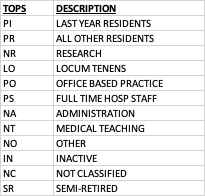

### Look at distribution of females by AMA type of service...not terribly enlightening

In [35]:
pd.crosstab(allNeuro.tops, allNeuro.female, dropna=True)

female,0,1
tops,,
IN,3801,536
LO,24,8
NA,215,53
NC,1073,836
NO,96,35
NR,737,158
NT,323,134
PI,610,421
PO,13871,4280


In [36]:
pd.crosstab(allNeuro.tops, allNeuro.female, dropna=True).apply(lambda r: r/r.sum(), axis=1)

female,0,1
tops,,
IN,0.876412,0.123588
LO,0.750000,0.250000
NA,0.802239,0.197761
NC,0.562074,0.437926
NO,0.732824,0.267176
NR,0.823464,0.176536
NT,0.706783,0.293217
PI,0.591659,0.408341
PO,0.764200,0.235800


### Look at distribution of females by AMA type of primary specialty

Neurology specialities from AMA masterfile

<li>MN	Internal Medicine - Neurology</li>
<li>N	Neurology</li>
<li>NDN	Neurodevelopmental Disabilities</li>
<li>NDP	Neurodevelopmental Disabilities</li>
<li>NMN	Neuromuscliar Medicine</li>
<li>NNM	Neurology / Nuclear Medicine</li>
<li>NS	Neurological Surgery</li>
<li>NSP	Pediatric Neurological Surgery</li>
<li>NUP	Neuropsychiatry</li>
<li>PMN	Pain Medicine (Neurology)</li>
<li>PYN	Psychiatry - Neurology</li>
<li>SMN	Sleep Medicine (Psych & Neurology)</li>
<li>VN	Vascliar Neurology</li>
<li>CHN Child neurology</li>

In [42]:
pd.crosstab(allNeuro.PrimarySpecialty, allNeuro.female, dropna=True).sort_values(0, ascending=False).head(20)

female,0,1
PrimarySpecialty,,
N,13179,5542
NS,7664,721
CHN,1156,1134
SME,858,469
P,557,105
VN,458,227
PCC,409,76
PUD,248,29
NO,234,42


In [43]:
pd.crosstab(allNeuro.PrimarySpecialty, allNeuro.female, dropna=True).sort_values(0, ascending=False).apply(lambda r: r/r.sum(), axis=1).head(20)

female,0,1
PrimarySpecialty,,
N,0.703969,0.296031
NS,0.914013,0.085987
CHN,0.504803,0.495197
SME,0.646571,0.353429
P,0.841390,0.158610
VN,0.668613,0.331387
PCC,0.843299,0.156701
PUD,0.895307,0.104693
NO,0.847826,0.152174


In [44]:
pd.crosstab(allNeuro.PrimarySpecialty, allNeuro.female, dropna=True).sort_values(0, ascending=False).head(20)

female,0,1
PrimarySpecialty,,
N,13179,5542
NS,7664,721
CHN,1156,1134
SME,858,469
P,557,105
VN,458,227
PCC,409,76
PUD,248,29
NO,234,42


So, women make up 30% of neurologists, 8.5% of neurosurgeons and 50% of child neuroloy

In [45]:
allNeuro['yog10'] = pd.qcut(allNeuro.YOGEst, 10)
allNeuro['yog10Count'] = pd.qcut(allNeuro.YOGEst, 10, labels=range(0,10))

Looking at the % of women based on year of med school graduation — interestingly, the % of women in neurology fell off in 2014+, after steadily increasing prior to that time... 

In [46]:
allNeuro[['yog10', 'female']].groupby("yog10").mean()

,female
yog10,
"(1927.999, 1970.0]",0.061176
"(1970.0, 1977.0]",0.096868
"(1977.0, 1983.0]",0.180819
"(1983.0, 1989.0]",0.206607
"(1989.0, 1994.0]",0.252543
"(1994.0, 2000.0]",0.280961
"(2000.0, 2005.0]",0.336792
"(2005.0, 2010.0]",0.393160
"(2010.0, 2013.0]",0.409047


In [48]:
rightMatch = neuroMatches[['lastName', 'firstName', 'meeting', 'homeInstitution', 'professionalRank', 'medGradYear', 'pubsScopus', 'scopusHIndex', 'leadership', 'speaker', 'honorificSpeaker', 'academic', 'us']].join(allNeuro, on='amaID', how='right')
rightMatch['matched'] = ~(rightMatch.lastName.isna())
rightMatch.reset_index(inplace=True)
rightMatch.reset_index(inplace=True)

def getCategory(x):
    matches = [x==y for y in ["N", 'NS', "CHN", 'P', 'VN', 'NMN', 'NO', 'SME']]
    return x if any(matches) else "Other"
rightMatch['simplifiedSpecialty'] = rightMatch.PrimarySpecialty.apply(getCategory)


### Primnary analysis — accounting for specialty and years since graduation...is there an effect of gender on the probability of presenting at a meeting

In [49]:
import statsmodels.formula.api as smf
import statsmodels.tools.tools as tools
#rightMatch['yog10'].astype('category')
#rightMatch = rightMatch[['matched', 'female', 'yog10Count']].dropna()
rightMatch = rightMatch[['matched', 'female', 'yog10Count', 'simplifiedSpecialty', 'meeting']]
rightMatch['matched'] = rightMatch.matched.astype('int')
adjusted = smf.logit(formula='matched ~ female + C(yog10Count) + C(simplifiedSpecialty) ', data=rightMatch)
adjustedResult = adjusted.fit()
unadjusted = smf.logit(formula='matched ~ female', data=rightMatch)
unadjustedResult = unadjusted.fit()
unadjustedResult.summary()

         Current function value: 0.099623
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.106882
         Iterations 8


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                matched   No. Observations:                35525
Model:                          Logit   Df Residuals:                    35523
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Dec 2018   Pseudo R-squ.:               0.0005840
Time:                        10:35:11   Log-Likelihood:                -3797.0
converged:                       True   LL-Null:                       -3799.2
                                        LLR p-value:                   0.03515
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8254      0.043    -89.953      0.000      -3.909      -3.742
female         0.1693      0.079      2.132      0.033       0.014       0.325
==============================================================================
"""

In [50]:
adjustedResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                matched   No. Observations:                34654
Model:                          Logit   Df Residuals:                    34635
Method:                           MLE   Df Model:                           18
Date:                Thu, 13 Dec 2018   Pseudo R-squ.:                 0.07919
Time:                        10:35:18   Log-Likelihood:                -3452.3
converged:                      False   LL-Null:                       -3749.2
                                        LLR p-value:                1.770e-114
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.9147      0.279    -17.597      0.000      -5.462      -4.367
C(yog10Count)[T.1]                  0.9791      0.293      3.338      0.001       0.404       1.554
C(yog10Count)[T.2]                  1.8780      0.270      6.952      0.000       1.349       2.407
C(yog10Count)[T.3]                  1.8998      0.270      7.046      0.000       1.371       2.428
C(yog10Count)[T.4]                  1.9109      0.270      7.075      0.000       1.382       2.440
C(yog10Count)[T.5]                  2.2004      0.265      8.310      0.000       1.681       2.719
C(yog10Count)[T.6]                  2.1546      0.269      8.024      0.000       1.628       2.681
C(yog10Count)[T.7]                  1.4584      0.281      5.187      0.000       0.907       2.010
C(yog10Count)[T.8]                  0.5785      0.318      1.819      0.069      -0.045       1.202
C(yog10Count)[T.9]                 -0.9471      0.481     -1.970      0.049      -1.889      -0.005
C(simplifiedSpecialty)[T.N]        -0.0890      0.132     -0.674      0.500      -0.348       0.170
C(simplifiedSpecialty)[T.NMN]      -0.8715      0.523     -1.668      0.095      -1.896       0.153
C(simplifiedSpecialty)[T.NO]      -20.8769   1.15e+04     -0.002      0.999   -2.25e+04    2.25e+04
C(simplifiedSpecialty)[T.NS]       -1.5931      0.188     -8.477      0.000      -1.961      -1.225
C(simplifiedSpecialty)[T.Other]    -1.2182      0.223     -5.458      0.000      -1.656      -0.781
C(simplifiedSpecialty)[T.P]        -1.6854      0.594     -2.836      0.005      -2.850      -0.521
C(simplifiedSpecialty)[T.SME]      -0.4435      0.238     -1.864      0.062      -0.910       0.023
C(simplifiedSpecialty)[T.VN]        0.4646      0.241      1.927      0.054      -0.008       0.937
female                             -0.0992      0.083     -1.191      0.234      -0.262       0.064
===================================================================================================
"""

In [51]:
adjustedYOG = smf.logit(formula='matched ~ female + C(yog10Count) ', data=rightMatch)
yogResult = adjustedYOG.fit()
yogResult.summary()

Optimization terminated successfully.
         Current function value: 0.102878
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                matched   No. Observations:                34654
Model:                          Logit   Df Residuals:                    34643
Method:                           MLE   Df Model:                           10
Date:                Thu, 13 Dec 2018   Pseudo R-squ.:                 0.04910
Time:                        10:36:40   Log-Likelihood:                -3565.1
converged:                       True   LL-Null:                       -3749.2
                                        LLR p-value:                 5.448e-73
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.4808      0.251    -21.872      0.000      -5.972      -4.990
C(yog10Count)[T.1]     1.1188      0.293      3.820      0.000       0.545       1.693
C(yog10Count)[T.2]     2.0173      0.270      7.481      0.000       1.489       2.546
C(yog10Count)[T.3]     2.0281      0.269      7.537      0.000       1.501       2.556
C(yog10Count)[T.4]     2.0458      0.269      7.592      0.000       1.518       2.574
C(yog10Count)[T.5]     2.2992      0.264      8.704      0.000       1.781       2.817
C(yog10Count)[T.6]     2.2720      0.267      8.502      0.000       1.748       2.796
C(yog10Count)[T.7]     1.6233      0.276      5.886      0.000       1.083       2.164
C(yog10Count)[T.8]     0.7605      0.314      2.423      0.015       0.145       1.376
C(yog10Count)[T.9]    -0.8759      0.480     -1.825      0.068      -1.817       0.065
female                 0.1234      0.082      1.508      0.132      -0.037       0.284
======================================================================================
"""

In [52]:
adjustedSpec = smf.logit(formula='matched ~ female + C(simplifiedSpecialty) ', data=rightMatch)
adjustedSpecResult = adjustedSpec.fit()
adjustedSpecResult.summary()

         Current function value: 0.103382
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                matched   No. Observations:                35525
Model:                          Logit   Df Residuals:                    35515
Method:                           MLE   Df Model:                            9
Date:                Thu, 13 Dec 2018   Pseudo R-squ.:                 0.03331
Time:                        10:36:50   Log-Likelihood:                -3672.7
converged:                      False   LL-Null:                       -3799.2
                                        LLR p-value:                 2.221e-49
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.4589      0.129    -26.791      0.000      -3.712      -3.206
C(simplifiedSpecialty)[T.N]         0.0291      0.131      0.222      0.824      -0.228       0.286
C(simplifiedSpecialty)[T.NMN]      -1.0565      0.518     -2.042      0.041      -2.071      -0.042
C(simplifiedSpecialty)[T.NO]      -16.7275   1462.016     -0.011      0.991   -2882.226    2848.771
C(simplifiedSpecialty)[T.NS]       -1.5748      0.187     -8.437      0.000      -1.941      -1.209
C(simplifiedSpecialty)[T.Other]    -0.9967      0.220     -4.536      0.000      -1.427      -0.566
C(simplifiedSpecialty)[T.P]        -1.9237      0.592     -3.248      0.001      -3.084      -0.763
C(simplifiedSpecialty)[T.SME]      -0.4333      0.233     -1.856      0.063      -0.891       0.024
C(simplifiedSpecialty)[T.VN]        0.3220      0.229      1.404      0.160      -0.127       0.771
female                             -0.0615      0.081     -0.759      0.448      -0.220       0.097
===================================================================================================
"""

In [53]:
rightMatch2 = rightMatch.loc[rightMatch.simplifiedSpecialty == "Other"]
adjustedSpecNS = smf.logit(formula='matched ~ female + C(simplifiedSpecialty) ', data=rightMatch2)
adjustedSpecResultNS = adjustedSpecNS.fit()
adjustedSpecResultNS.summary()

Optimization terminated successfully.
         Current function value: 0.061456
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                matched   No. Observations:                 2735
Model:                          Logit   Df Residuals:                     2733
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Dec 2018   Pseudo R-squ.:                0.009535
Time:                        10:36:56   Log-Likelihood:                -168.08
converged:                       True   LL-Null:                       -169.70
                                        LLR p-value:                   0.07203
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.6672      0.225    -20.775      0.000      -5.108      -4.227
female         0.7090      0.378      1.874      0.061      -0.032       1.450
==============================================================================
"""

### Across the linked specialities, no associatio between gender and the probability of presenting before or after adjustment

In [54]:
rightMatch.simplifiedSpecialty.value_counts()

N        18775
NS        8386
Other     2735
CHN       2295
SME       1328
VN         686
P          662
NMN        382
NO         276
Name: simplifiedSpecialty, dtype: int64

### Next, let's look at differences across meetings...

In [55]:
pd.crosstab(meetings.matchCategory, meetings.meeting)

meeting,AAN,AES,ISC,SNO,Sleep
matchCategory,,,,,
neuroMatch,398,137,177,34,47
nonNeuroMatch,54,32,50,34,48
nonus,18,57,161,22,17
unmatched,42,48,69,16,33


In [56]:
pd.crosstab(meetings.meeting, meetings.matchCategory ).apply(lambda r: r/r.sum(), axis=1)

matchCategory,neuroMatch,nonNeuroMatch,nonus,unmatched
meeting,,,,
AAN,0.777344,0.105469,0.035156,0.082031
AES,0.500000,0.116788,0.208029,0.175182
ISC,0.387309,0.109409,0.352298,0.150985
SNO,0.320755,0.320755,0.207547,0.150943
Sleep,0.324138,0.331034,0.117241,0.227586


In [57]:
pd.crosstab( meetings.meeting, meetings.female, dropna=True).apply(lambda r : r/r.sum(), axis=1)

female,0.0,1.0
meeting,,
AAN,0.683594,0.316406
AES,0.686347,0.313653
ISC,0.783848,0.216152
SNO,0.721154,0.278846
Sleep,0.696552,0.303448


### Most of the meetings look pretty good, but for the ISC...which also has a larger intertnainol presence

In [58]:
pd.crosstab( usmeetings.meeting, usmeetings.female, dropna=True).apply(lambda r : r/r.sum(), axis=1)

female,-1,0,1
meeting,,,
AAN,0.000000,0.684211,0.315789
AES,0.000000,0.668203,0.331797
ISC,0.010135,0.733108,0.256757
SNO,0.000000,0.738095,0.261905
Sleep,0.000000,0.679688,0.320312


### AES + ISC + Sleep both do a bit betyter when you drop international presenters

In [59]:
meetingTypes =  ['AAN', 'ISC', 'AES', 'SNO'] # omitting sleep...because its quite tiny
results = {}

def predictIndividualMeetings(meetingType):
    matchVarName = 'matchded' + meetingType
    rightMatch[matchVarName] = (rightMatch.matched) & (rightMatch.meeting==meetingType)
    rightMatch[matchVarName] = rightMatch[matchVarName].astype('int')
    adjusted = smf.logit(formula=matchVarName + '~ female + C(yog10Count) + C(simplifiedSpecialty)', data=rightMatch)
    output = adjusted.fit()
    results[meetingType] = output

for meeting in meetingTypes:
    predictIndividualMeetings(meeting)

         Current function value: 0.101607
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.029125
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.022980
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.006639
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [60]:
results['AAN'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            matchdedAAN   No. Observations:                34654
Model:                          Logit   Df Residuals:                    34635
Method:                           MLE   Df Model:                           18
Date:                Thu, 13 Dec 2018   Pseudo R-squ.:                 -0.6301
Time:                        10:38:08   Log-Likelihood:                -3521.1
converged:                      False   LL-Null:                       -2160.1
                                        LLR p-value:                     1.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -5.7647      0.363    -15.872      0.000      -6.477      -5.053
C(yog10Count)[T.1]                  0.5606      0.342      1.640      0.101      -0.109       1.231
C(yog10Count)[T.2]                  1.5629      0.304      5.148      0.000       0.968       2.158
C(yog10Count)[T.3]                  1.4352      0.306      4.687      0.000       0.835       2.035
C(yog10Count)[T.4]                  1.0132      0.321      3.153      0.002       0.383       1.643
C(yog10Count)[T.5]                  1.5503      0.303      5.119      0.000       0.957       2.144
C(yog10Count)[T.6]                  1.6352      0.308      5.310      0.000       1.032       2.239
C(yog10Count)[T.7]                  1.3576      0.318      4.264      0.000       0.734       1.982
C(yog10Count)[T.8]                 -0.6384      0.490     -1.303      0.193      -1.599       0.322
C(yog10Count)[T.9]                -22.4155   1606.630     -0.014      0.989   -3171.352    3126.521
C(simplifiedSpecialty)[T.N]         0.7682      0.244      3.146      0.002       0.290       1.247
C(simplifiedSpecialty)[T.NMN]       0.3573      0.563      0.634      0.526      -0.747       1.462
C(simplifiedSpecialty)[T.NO]       11.0426      1.144      9.651      0.000       8.800      13.285
C(simplifiedSpecialty)[T.NS]       -3.1191      0.626     -4.986      0.000      -4.345      -1.893
C(simplifiedSpecialty)[T.Other]    -1.0598      0.411     -2.578      0.010      -1.866      -0.254
C(simplifiedSpecialty)[T.P]       -20.9150    1.6e+04     -0.001      0.999   -3.14e+04    3.14e+04
C(simplifiedSpecialty)[T.SME]      -0.2716      0.414     -0.656      0.512      -1.083       0.540
C(simplifiedSpecialty)[T.VN]       -0.6179      0.633     -0.977      0.329      -1.858       0.622
female                             -0.1148      0.116     -0.991      0.322      -0.342       0.112
===================================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [61]:
results['ISC'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            matchdedISC   No. Observations:                34654
Model:                          Logit   Df Residuals:                    34635
Method:                           MLE   Df Model:                           18
Date:                Thu, 13 Dec 2018   Pseudo R-squ.:                 0.08249
Time:                        10:38:13   Log-Likelihood:                -1009.3
converged:                      False   LL-Null:                       -1100.0
                                        LLR p-value:                 4.901e-29
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -7.8586      0.817     -9.624      0.000      -9.459      -6.258
C(yog10Count)[T.1]                  1.5258      0.782      1.950      0.051      -0.008       3.059
C(yog10Count)[T.2]                  1.9217      0.761      2.527      0.012       0.431       3.412
C(yog10Count)[T.3]                  2.3231      0.743      3.128      0.002       0.867       3.779
C(yog10Count)[T.4]                  2.7621      0.732      3.775      0.000       1.328       4.196
C(yog10Count)[T.5]                  2.8954      0.727      3.983      0.000       1.471       4.320
C(yog10Count)[T.6]                  2.6430      0.736      3.591      0.000       1.201       4.086
C(yog10Count)[T.7]                  1.3318      0.776      1.717      0.086      -0.188       2.852
C(yog10Count)[T.8]                  1.3957      0.782      1.786      0.074      -0.136       2.928
C(yog10Count)[T.9]                  1.0125      0.839      1.207      0.227      -0.632       2.657
C(simplifiedSpecialty)[T.N]         0.6951      0.421      1.650      0.099      -0.131       1.521
C(simplifiedSpecialty)[T.NMN]     -20.7830   4.01e+04     -0.001      1.000   -7.87e+04    7.86e+04
C(simplifiedSpecialty)[T.NO]      -14.9287   2088.375     -0.007      0.994   -4108.068    4078.211
C(simplifiedSpecialty)[T.NS]        0.1016      0.458      0.222      0.824      -0.796       0.999
C(simplifiedSpecialty)[T.Other]    -0.5782      0.609     -0.950      0.342      -1.772       0.615
C(simplifiedSpecialty)[T.P]       -21.0740    3.4e+04     -0.001      1.000   -6.67e+04    6.66e+04
C(simplifiedSpecialty)[T.SME]      -1.1041      1.085     -1.018      0.309      -3.231       1.023
C(simplifiedSpecialty)[T.VN]        3.0448      0.488      6.234      0.000       2.088       4.002
female                             -0.2598      0.184     -1.415      0.157      -0.620       0.100
===================================================================================================
"""

In [55]:
results['AES'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            matchdedAES   No. Observations:                31714
Model:                          Logit   Df Residuals:                    31697
Method:                           MLE   Df Model:                           16
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                  0.1097
Time:                        09:03:10   Log-Likelihood:                -761.52
converged:                      False   LL-Null:                       -855.31
                                        LLR p-value:                 2.539e-31
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -6.3386      1.013     -6.257      0.000      -8.324      -4.353
C(yog10Count)[T.1]                  1.8017      1.070      1.684      0.092      -0.296       3.899
C(yog10Count)[T.2]                  2.6133      1.029      2.540      0.011       0.597       4.630
C(yog10Count)[T.3]                  2.9323      1.025      2.859      0.004       0.922       4.942
C(yog10Count)[T.4]                  3.1255      1.022      3.058      0.002       1.122       5.129
C(yog10Count)[T.5]                  3.4141      1.019      3.352      0.001       1.418       5.411
C(yog10Count)[T.6]                  2.6410      1.031      2.561      0.010       0.620       4.662
C(yog10Count)[T.7]                  1.2400      1.123      1.104      0.270      -0.962       3.442
C(yog10Count)[T.8]                  1.2481      1.101      1.134      0.257      -0.910       3.406
C(yog10Count)[T.9]                -16.0681   3215.037     -0.005      0.996   -6317.425    6285.289
C(simplifiedSpecialty)[T.N]        -1.6350      0.199     -8.202      0.000      -2.026      -1.244
C(simplifiedSpecialty)[T.NMN]     -18.1990   4888.402     -0.004      0.997   -9599.290    9562.892
C(simplifiedSpecialty)[T.NS]       -2.8207      0.377     -7.488      0.000      -3.559      -2.082
C(simplifiedSpecialty)[T.Other]    -1.9250      0.529     -3.641      0.000      -2.961      -0.889
C(simplifiedSpecialty)[T.P]        -2.1218      1.019     -2.082      0.037      -4.120      -0.124
C(simplifiedSpecialty)[T.VN]      -69.8219      6e+14  -1.16e-13      1.000   -1.18e+15    1.18e+15
female                              0.0084      0.195      0.043      0.966      -0.373       0.390
===================================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [56]:
results['SNO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            matchdedSNO   No. Observations:                31714
Model:                          Logit   Df Residuals:                    31697
Method:                           MLE   Df Model:                           16
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                  0.1135
Time:                        09:03:10   Log-Likelihood:                -224.07
converged:                      False   LL-Null:                       -252.74
                                        LLR p-value:                 1.451e-06
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -23.3995   1342.309     -0.017      0.986   -2654.276    2607.478
C(yog10Count)[T.1]                 -5.5630   2.21e+04     -0.000      1.000   -4.32e+04    4.32e+04
C(yog10Count)[T.2]                 -5.6065   2.14e+04     -0.000      1.000    -4.2e+04     4.2e+04
C(yog10Count)[T.3]                 15.4941   1342.309      0.012      0.991   -2615.382    2646.371
C(yog10Count)[T.4]                 16.2001   1342.309      0.012      0.990   -2614.676    2647.076
C(yog10Count)[T.5]                 16.4107   1342.309      0.012      0.990   -2614.466    2647.287
C(yog10Count)[T.6]                 16.4114   1342.309      0.012      0.990   -2614.465    2647.288
C(yog10Count)[T.7]                 16.5957   1342.309      0.012      0.990   -2614.281    2647.472
C(yog10Count)[T.8]                 -5.5588   2.13e+04     -0.000      1.000   -4.18e+04    4.18e+04
C(yog10Count)[T.9]                 -6.0700   3.06e+04     -0.000      1.000   -5.99e+04    5.99e+04
C(simplifiedSpecialty)[T.N]         0.8414      1.031      0.816      0.415      -1.180       2.863
C(simplifiedSpecialty)[T.NMN]     -24.7771   4.98e+05  -4.98e-05      1.000   -9.76e+05    9.76e+05
C(simplifiedSpecialty)[T.NS]        1.4047      1.055      1.332      0.183      -0.662       3.472
C(simplifiedSpecialty)[T.Other]   -45.4479    1.1e+10  -4.13e-09      1.000   -2.16e+10    2.16e+10
C(simplifiedSpecialty)[T.P]        -7.2774    144.534     -0.050      0.960    -290.558     276.004
C(simplifiedSpecialty)[T.VN]      -28.1972   1.97e+06  -1.43e-05      1.000   -3.86e+06    3.86e+06
female                              0.0820      0.419      0.195      0.845      -0.740       0.904
===================================================================================================

Possibly complete quasi-separation: A fraction 0.54 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Upshot: No meeting has a significant gender effect

In [110]:
meetings['anySpeaker'] = meetings.speaker >= 1
meetings['anySpeaker'] = meetings['anySpeaker'].astype(int)
usmeetings['anySpeaker'] = usmeetings.speaker >= 1
usmeetings['anySpeaker'] = usmeetings['anySpeaker'].astype(int)

meetings['anyLeadership'] = meetings.leadership >= 1
meetings['anyLeadership'] = meetings['anyLeadership'].astype(int)

usmeetings['anyLeadership'] = usmeetings.leadership >= 1
usmeetings['anyLeadership'] = usmeetings['anyLeadership'].astype(int)




meetings['yearsFromGraduation'] = 2018-meetings.medGradYear
usmeetings['yearsFromGraduation'] = 2018-usmeetings.medGradYear

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [111]:
meetings['professionalRank'] = meetings.professionalRank.str.strip()
usmeetings['professionalRank'] = usmeetings.professionalRank.str.strip()

def getSimpleRank(x):
    if isinstance(x, str):
        if "associate" in x.lower():
            return "associate"
        elif "assistant" in x.lower():
            return "assistant"
        elif ("professor" in x.lower()) and ("associate" not in x.lower()) and ("assistant" not in x.lower()):
            return "professor"
        else:
            return "other"    
    else:
        return "no rank"

meetings['simpleRank'] = meetings.professionalRank.apply(getSimpleRank)
usmeetings['simpleRank'] = usmeetings.professionalRank.apply(getSimpleRank)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [112]:
aan = meetings.loc[meetings.meeting=='AAN']

In [107]:
unadjustedSpeakerModel = smf.logit(formula='anySpeaker ~ female ', data=aan)
unadjustedSpeakerResult = unadjustedSpeakerModel.fit()
unadjustedSpeakerResult.summary()

Optimization terminated successfully.
         Current function value: 0.422913
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             anySpeaker   No. Observations:                  512
Model:                          Logit   Df Residuals:                      510
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                0.001117
Time:                        09:40:07   Log-Likelihood:                -216.53
converged:                       True   LL-Null:                       -216.77
                                        LLR p-value:                    0.4866
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7918      0.153     11.730      0.000       1.492       2.091
female        -0.1823      0.260     -0.700      0.484      -0.693       0.328
==============================================================================
"""

In [105]:
speakerModel = smf.logit(formula='anySpeaker ~ female +C(simpleRank) + yearsFromGraduation + pubsScopus + scopusHIndex + academic', data=aan)
speakerResult = speakerModel.fit()
speakerResult.summary()

         Current function value: 0.410414
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             anySpeaker   No. Observations:                  495
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                            9
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                 0.02707
Time:                        09:37:44   Log-Likelihood:                -203.15
converged:                      False   LL-Null:                       -208.81
                                        LLR p-value:                    0.2554
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      2.2780      1.106      2.059      0.039       0.110       4.446
C(simpleRank)[T.associate]     0.6667      0.419      1.592      0.111      -0.154       1.488
C(simpleRank)[T.no rank]      -0.7462      0.936     -0.798      0.425      -2.580       1.088
C(simpleRank)[T.other]        17.7535   7087.815      0.003      0.998   -1.39e+04    1.39e+04
C(simpleRank)[T.professor]     0.2769      0.459      0.604      0.546      -0.622       1.176
female                        -0.2894      0.281     -1.030      0.303      -0.840       0.261
yearsFromGraduation           -0.0222      0.016     -1.364      0.173      -0.054       0.010
pubsScopus                     0.0011      0.001      0.759      0.448      -0.002       0.004
scopusHIndex                  -0.0007      0.006     -0.105      0.916      -0.013       0.012
academic                      -0.1960      1.028     -0.191      0.849      -2.212       1.820
==============================================================================================
"""

In [106]:
speakerModelPoisson = smf.poisson(formula='speaker ~ female +C(simpleRank) + yearsFromGraduation + pubsScopus + scopusHIndex + academic', data=aan)
speakerResultPoisson = speakerModelPoisson.fit()
speakerResultPoisson.summary()

Optimization terminated successfully.
         Current function value: 1.462402
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                speaker   No. Observations:                  495
Model:                        Poisson   Df Residuals:                      485
Method:                           MLE   Df Model:                            9
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                 0.01343
Time:                        09:37:55   Log-Likelihood:                -723.89
converged:                       True   LL-Null:                       -733.74
                                        LLR p-value:                   0.01978
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2840      0.528      0.537      0.591      -0.752       1.320
C(simpleRank)[T.associate]     0.2970      0.118      2.517      0.012       0.066       0.528
C(simpleRank)[T.no rank]      -0.2759      0.460     -0.599      0.549      -1.178       0.626
C(simpleRank)[T.other]         0.6256      0.314      1.992      0.046       0.010       1.241
C(simpleRank)[T.professor]     0.2325      0.145      1.606      0.108      -0.051       0.516
female                         0.0799      0.083      0.960      0.337      -0.083       0.243
yearsFromGraduation           -0.0052      0.005     -1.004      0.315      -0.015       0.005
pubsScopus                     0.0008      0.000      1.954      0.051   -2.64e-06       0.002
scopusHIndex                  -0.0009      0.002     -0.407      0.684      -0.005       0.004
academic                      -0.0865      0.513     -0.169      0.866      -1.093       0.920
==============================================================================================
"""

### Upshot — no difference in # of talks or prob of talks at AAN

In [113]:
leadershipModel = smf.logit(formula='anyLeadership ~ female +C(simpleRank) + yearsFromGraduation + pubsScopus + scopusHIndex + academic', data=aan)
leadershipResult = leadershipModel.fit()
leadershipResult.summary()

Optimization terminated successfully.
         Current function value: 0.686378
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          anyLeadership   No. Observations:                  495
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                            9
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                0.009413
Time:                        09:42:44   Log-Likelihood:                -339.76
converged:                       True   LL-Null:                       -342.99
                                        LLR p-value:                    0.6934
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.6752      0.997     -0.677      0.498      -2.630       1.280
C(simpleRank)[T.associate]     0.3878      0.276      1.403      0.161      -0.154       0.929
C(simpleRank)[T.no rank]       0.2153      0.855      0.252      0.801      -1.461       1.892
C(simpleRank)[T.other]        -1.0609      1.137     -0.933      0.351      -3.290       1.168
C(simpleRank)[T.professor]     0.0865      0.337      0.257      0.797      -0.573       0.746
female                         0.1124      0.201      0.558      0.577      -0.282       0.507
yearsFromGraduation            0.0105      0.012      0.865      0.387      -0.013       0.034
pubsScopus                    -0.0004      0.001     -0.367      0.714      -0.002       0.002
scopusHIndex                   0.0035      0.005      0.650      0.516      -0.007       0.014
academic                       0.1398      0.955      0.146      0.884      -1.732       2.011
==============================================================================================
"""

In [114]:
leadershipResultPoisson = smf.poisson(formula='anyLeadership ~ female +C(simpleRank) + yearsFromGraduation + pubsScopus + scopusHIndex + academic', data=aan)
speakerResultPoisson = leadershipResultPoisson.fit()
speakerResultPoisson.summary()

Optimization terminated successfully.
         Current function value: 0.835248
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:          anyLeadership   No. Observations:                  495
Model:                        Poisson   Df Residuals:                      485
Method:                           MLE   Df Model:                            9
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                0.004173
Time:                        09:43:43   Log-Likelihood:                -413.45
converged:                       True   LL-Null:                       -415.18
                                        LLR p-value:                    0.9430
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.0418      0.711     -1.466      0.143      -2.435       0.351
C(simpleRank)[T.associate]     0.2038      0.199      1.023      0.306      -0.187       0.594
C(simpleRank)[T.no rank]       0.1157      0.607      0.191      0.849      -1.074       1.305
C(simpleRank)[T.other]        -0.7419      1.011     -0.734      0.463      -2.723       1.239
C(simpleRank)[T.professor]     0.0565      0.244      0.232      0.817      -0.421       0.534
female                         0.0576      0.143      0.403      0.687      -0.223       0.338
yearsFromGraduation            0.0053      0.009      0.628      0.530      -0.011       0.022
pubsScopus                    -0.0001      0.001     -0.216      0.829      -0.001       0.001
scopusHIndex                   0.0014      0.003      0.475      0.635      -0.004       0.007
academic                       0.0682      0.679      0.100      0.920      -1.263       1.399
==============================================================================================
"""